<a href="https://colab.research.google.com/github/Fedor102/Spam-or-Not-Spam/blob/main/SMS_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Загружаем датасет "SMS Spam Collection Dataset" скачанный с Kaggle
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "archive.zip" -d ./dataset

In [ ]:
# Библиотека матричного вычисления
import numpy as np
# Библиотека для работы с данными
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf
# Библиотеки для построения графиков и их стилизации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import chardet

# Откройте файл в бинарном режиме и определите его кодировку
with open('./dataset/spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

# Прочтите файл с найденной кодировкой
df_spam = pd.read_csv('./dataset/spam.csv', encoding=result['encoding'])

# Просмотр первых строк
df_spam.head()

{'encoding': 'Windows-1252', 'confidence': 0.7269493857068697, 'language': ''}


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Удаляем колонку со ссылками на статьи
df_spam = df_spam.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis = 1)

In [ ]:
# Просмотр первых строк
df_spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print('Найдено дубликатов: ', df_spam.duplicated().sum())

# Удаляем дубликаты
df_spam.drop_duplicates(subset=['v2'], inplace = True)

print('Осталось дубликатов после очистки: ', df_spam.duplicated().sum())

Найдено дубликатов:  403
Осталось дубликатов после очистки:  0


In [ ]:
#Создание обучающей, проверочной и тестовой выборок
#Создание обучающей и временной выборки(которую будем потом делить на проверочную и тестовую)
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_spam.v2),
                                                  np.array(df_spam.v1),
                                                  test_size=0.3)
#Создание проверочной и тестовой выборки из временной
X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                  y_tmp,
                                                  test_size=0.5)

In [ ]:
#Посмотрим на форму обучающей выборки и пример первого заголовка в выборке
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[3])
print('Пример выходных меток: ', y_train[3])

Форма входных данных:  (3618,)
Форма выходных меток:  (3618,)
Пример заголовка:  \Gimme a few\" was  &lt;#&gt;  minutes ago"
Пример выходных меток:  ham


In [ ]:
# Для экономии ОЗУ удаляем уже ненужные данные, после чего python запускает сборщик "мусора" для очистки памяти
del df_spam, X_tmp, y_tmp

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf

# Импортируем фреймворк Keras
import keras

# Для работы с слоями
from keras import layers,regularizers

# Тюнеры для KerasTuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Для быстрой векторизации слов
from tensorflow.keras.preprocessing.text import one_hot

# Выравнивание последовательностей по длиине
from keras.preprocessing.sequence import pad_sequences

<ipython-input-13-ec7008fe8438>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Задаем размер словаря
vocab_size = 5000

# Выравниваем входные последовательности до заданной длины
sentence_len = 20

# Функция предобработки данных
def data_preparation(data):
    corpus=[]

    for text in data:
        # убираем из текстов все, что не является буквами
        text=re.sub("[^a-zA-Z]", " ", text)
        # Убираем все заглавные буквы
        text=text.lower()
        # Избавляемся от лишних пробелов
        text=text.split()
        text=" ".join(text)
        corpus.append(text)

    # Векторизуем текст
    oneHot_doc=[one_hot(input_text=words, n=vocab_size)
               for words in corpus
               ]
    # обрезаем или забиваем нулями до заданной длины входные последовательности
    embedded_doc=pad_sequences(sequences=oneHot_doc,
                              maxlen=sentence_len,
                              padding="post")
    return embedded_doc

In [ ]:
# Запускаем предобработку данных
train_data = data_preparation(X_train)
test_data = data_preparation(X_test)

In [ ]:
# Вывод первого заголовка обучающей выборки в исходном виде
X_train[0]

"Neva mind it's ok.."

In [ ]:
# Вывод первого заголовка обучающей выборки в векторизованном виде
train_data[0]

array([3331,  583,  848, 4588, 4680,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Преобразование меток в числовые значения
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels

In [ ]:
# Преобразование меток
y_train = encode_labels(y_train)  # Предполагается, что y_train содержит метки для X_train
y_test = encode_labels(y_test)

In [ ]:
y_train

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
# Определение функции для построения модели
def build_model(hp):
    model = keras.Sequential()
    # Добавление слоев эмбеддинга
    model.add(layers.Embedding(input_dim=vocab_size,
      output_dim=hp.Int('embedding_dim', min_value=8, max_value=32, step=8) # задаем диапазон изменения параметра embedding_dim
    ))
    # Выбор метода пулинга
    pooling_type = hp.Choice('pooling', ['global_average', 'global_max'])
    if pooling_type == 'global_average':
        model.add(layers.GlobalAveragePooling1D())
    else:
        model.add(layers.GlobalMaxPooling1D())

    # Задаем количество слоев, их размерности и функции активации
    for i in range(hp.Int('num_layers', 1, 4)): # число слоев
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), # размерность
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid']))) # подбор функции активации

        model.add(layers.BatchNormalization())  # Batch Normalization
        model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0.2, 0.5, step=0.1)))  # Dropout
    model.add(layers.Dense(1, activation='sigmoid')) # Выходной слой

    # Определение оптимизатора и скомпилирование модели
    # learning_rate - выбирается из списка [1e-3, 1e-4, 1e-5]
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Определение гиперпараметров для настройки
tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=10,
                            directory='output')

# Запуск настройки гиперпараметров
tuner_search.search(train_data, y_train, epochs=10, validation_split=0.2)


Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.8259668350219727

Best val_accuracy So Far: 0.9875690340995789
Total elapsed time: 00h 01m 29s


In [ ]:
# Получение наилучшей модели
best_model = tuner_search.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 16)              │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 96)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96)                  │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,113 (320.75 KB)

 Trainable params: 81,921 (320.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Обучаем лучшую модель и получаем историю
history = best_model.fit(train_data, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9848 - val_loss: 0.0798
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3705e-04 - val_accuracy: 0.9834 - val_loss: 0.1097
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.7629e-04 - val_accuracy: 0.9820 - val_loss: 0.1168
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9793 - val_loss: 0.1414
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9793 - val_loss: 0.1346
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0051 - val_accuracy: 0.9820 - val_loss: 0.1146
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9820 - val_loss: 0.1382
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9807 - v

In [ ]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

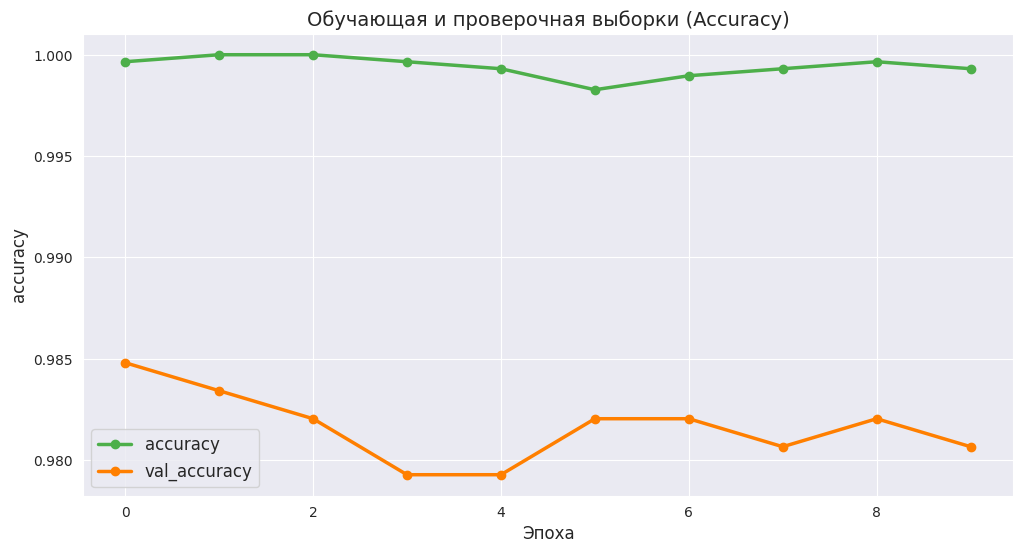

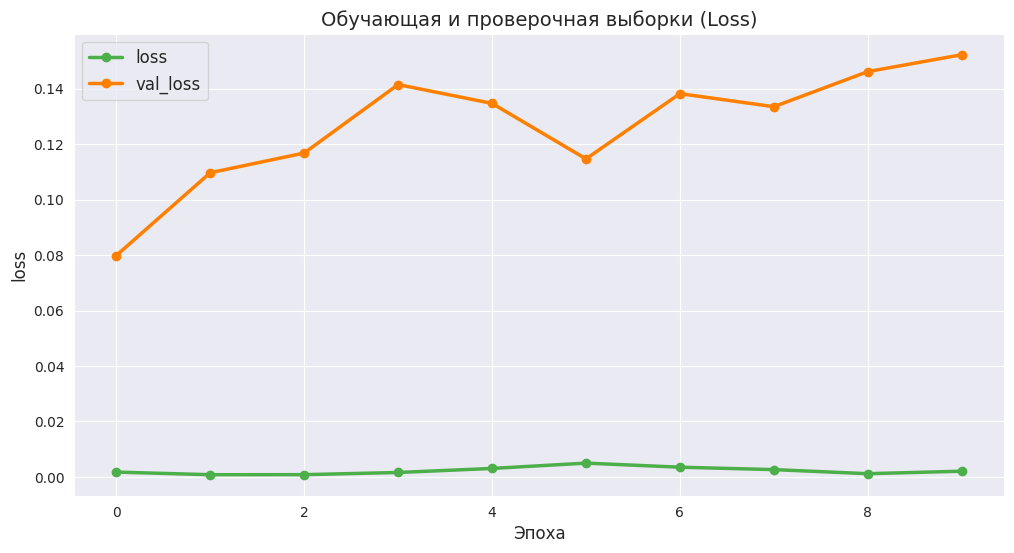

In [ ]:
# строим график точности
plot_graphs(history, "accuracy")

# строим график потерь
plot_graphs(history, "loss")

In [ ]:
# Предсказание на лучшей модели
predicted_y = best_model.predict(test_data)

# Оценка лучшей модели на тестовых данных
print(best_model.evaluate(test_data, y_test))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.1930 
[0.18281468749046326, 0.9742268323898315]


In [ ]:
# Получение предсказаний модели
predicted_y = best_model.predict(test_data)
# Если модель выводит вероятности, нужно преобразовать их в метки классов
predicted_y_classes = (predicted_y > 0.5).astype(int)  # Для бинарной классификации

# Печать отчета о классификации
print(classification_report(y_test, predicted_y_classes))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       675
           1       0.95      0.85      0.90       101

    accuracy                           0.97       776
   macro avg       0.96      0.92      0.94       776
weighted avg       0.97      0.97      0.97       776



In [ ]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, predicted_y_classes)

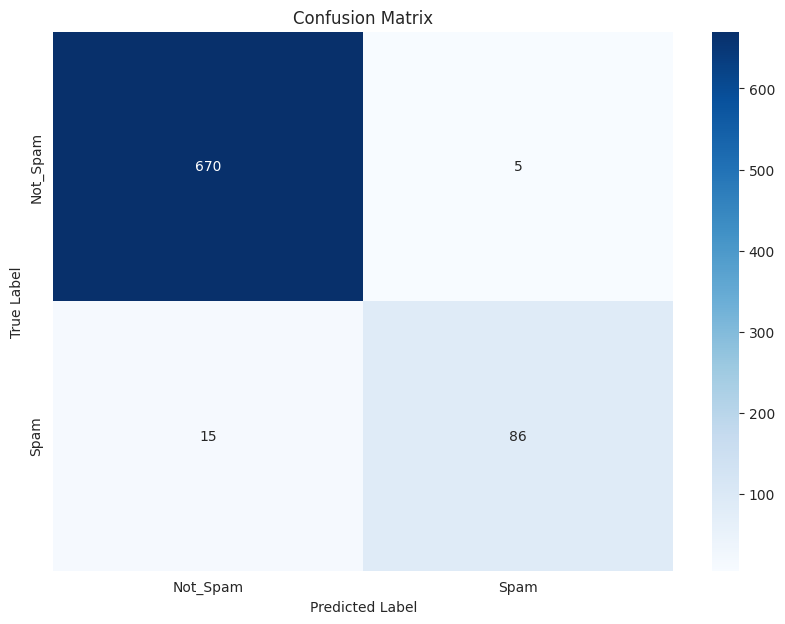

In [ ]:
# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not_Spam', 'Spam'],
            yticklabels=['Not_Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Функция для предсказания наличия спама
def predict_spam(text, model):
    # Подготовка текста
    # Векторизация текста
    text_sequence = data_preparation([text])
    # Выравнивание последовательности
    text_sequence = pad_sequences(text_sequence, maxlen=sentence_len)
    # Предсказание
    result = model.predict(text_sequence)
    # Получение метки класса (бинарная классификация: 0 или 1)
    predicted_class = (result > 0.5).astype(int)
    if predicted_class == 0:
        print("Предложение: '{}' НЕ СОДЕРЖИТ СПАМ.".format(text))
        print(f"Predicted Class (Numeric Label): {result[0]}")
    elif predicted_class == 1:
        print("Предложение: '{}' СОДЕРЖИТ СПАМ.".format(text))
        print(f"Predicted Class (Numeric Label): {result[0]}")




In [ ]:
#Создаём 5 примеров с сообщениями
spam_1 = "Congratulations! You've been selected for a special offer. Get a $500 gift card for free! Click this link to claim your prize now. Hurry, this offer ends soon!"
spam_2 = "Dear User, your account has been compromised. Please provide your username and password to verify your identity and secure your account. Failure to do so may result in suspension of your account."
spam_3 = "Earn $2000 a week working from home! No experience needed. Just click this link to start your application and start making money today. Limited spots available!"
spam_4 = "You’ve won a free vacation! Reply to this message with your contact details and get a complimentary trip to a tropical destination. Don’t miss out on this exclusive opportunity!"
spam_5 = "This is an urgent notice from your bank. Your account has been flagged for suspicious activity. Please follow this link to verify your information immediately to avoid any interruption in your services."

In [ ]:
# Выполнение функции
predict_spam(spam_1, best_model)
predict_spam(spam_2, best_model)
predict_spam(spam_3, best_model)
predict_spam(spam_4, best_model)
predict_spam(spam_5, best_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предложение: 'Congratulations! You've been selected for a special offer. Get a $500 gift card for free! Click this link to claim your prize now. Hurry, this offer ends soon!' СОДЕРЖИТ СПАМ.
Predicted Class (Numeric Label): [0.9989079]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Предложение: 'Dear User, your account has been compromised. Please provide your username and password to verify your identity and secure your account. Failure to do so may result in suspension of your account.' СОДЕРЖИТ СПАМ.
Predicted Class (Numeric Label): [0.9999301]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Предложение: 'Earn $2000 a week working from home! No experience needed. Just click this link to start your application and start making money today. Limited spots available!' НЕ СОДЕРЖИТ СПАМ.
Predicted Class (Numeric Label): [2.2440679e-08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Предложение: 'You’ve won a free vacation! Reply to this message with your contact details and get a